# RSI momentum trading strategy example

- This is a backtest example notebook
    - Instead of daily candles, use 8h candles and 3 times a day decision cycle

# Set up

Set up Trading Strategy data client.


In [1]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

# Render for Github web viewer
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)
# etup_charting_and_output(width=1500, height=1000)

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Load data

We use Binance data so we get a longer period of data.

In [2]:
import datetime
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.utils.binance import create_binance_universe

strategy_universe = create_binance_universe(
    ["BTCUSDT", "ETHUSDT"],   # Binance internal tickers later mapped to Trading strategy DEXPair metadata class
    candle_time_bucket=TimeBucket.h8,
    stop_loss_time_bucket=TimeBucket.h1,
    start_at=datetime.datetime(2019, 1, 1),  # Backtest for 5 years data
    end_at=datetime.datetime(2024, 1, 1),
    include_lending=False
)


  0%|          | 0/2 [00:00<?, ?it/s]

# Show loaded trading universe

Display generic troubleshooting information about the loaded data.

In [3]:
pairs = strategy_universe.data_universe.pairs  # Trading pairs metadata
candles = strategy_universe.data_universe.candles  # Candles for all trading pairs

print(f"Loaded {candles.get_candle_count():,} candles.")

for pair in pairs.iterate_pairs():
    pair_candles = candles.get_candles_by_pair(pair)
    first_close = pair_candles.iloc[0]["close"]
    first_close_at = pair_candles.index[0]
    print(f"Pair {pair} first close price {first_close} at {first_close_at}")

Loaded 10,958 candles.
Pair <Pair #1 BTC - USDT at exchange binance> first close price 3713.83 at 2019-01-01 00:00:00
Pair <Pair #2 ETH - USDT at exchange binance> first close price 133.56 at 2019-01-01 00:00:00


# Trading algorithm

In [4]:
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.weighting import weight_equal, weight_by_1_slash_n, weight_passthrouh
from tradeexecutor.strategy.alpha_model import AlphaModel
import numpy as np
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradingstrategy.chain import ChainId
from typing import List, Dict

from pandas_ta.momentum import rsi
import pandas as pd

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.state.visualisation import PlotKind, PlotShape, PlotLabel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.state.state import State

# List of pair descriptions we used to look up pair metadata
our_pairs = [
    (ChainId.centralised_exchange, "binance", "BTC", "USDT"),
    (ChainId.centralised_exchange, "binance", "ETH", "USDT"),
]

def decide_trades(
    timestamp: pd.Timestamp,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    state: State,
    pricing_model: PricingModel,
) -> List[TradeExecution]:

    # Resolve our pair metadata for our two pair strategy
    position_manager = PositionManager(timestamp, strategy_universe, state, pricing_model)
    alpha_model = AlphaModel(timestamp)
    btc_pair = position_manager.get_trading_pair(our_pairs[0])
    eth_pair = position_manager.get_trading_pair(our_pairs[1])

    position_manager.log("decide_trades() start")

    #
    # Indicators
    #
    # Calculate indicators for each pair.
    #

    # Per-trading pair calcualted data
    close_prices = {btc_pair: None, eth_pair: None}  # Recent close prices
    current_rsi_values = {}  # RSI yesterday
    previous_rsi_values = {}  # RSI day before yesterday
    current_price = {}  # Close price yesterday
    momentum = {btc_pair: 0, eth_pair: 0}
    eth_btc_rsi_yesterday = None

    for pair in [btc_pair, eth_pair]:

        pair_candles = candles.get_last_entries_by_pair_and_timestamp(pair.internal_id, timestamp)
        close_prices[pair] = pair_candles["close"]

        assert pair_candles is not None
        rsi_series = rsi(pair_candles["close"], length=parameters.rsi_bars)  # Will return None if the data buffer does not have enough days to look back

        # Reset indicators for this cycle and this pair
        current_rsi_values[pair] = None
        previous_rsi_values[pair] = None
        current_price[pair] = None
        price_today = None

        if len(pair_candles) > 0:
            # We have enough data to get the latest price
            current_price[pair] = price_today = pair_candles["close"][-1]

        if rsi_series is not None:
            current_val = rsi_series[-1]
            if np.isfinite(current_val):
                # We have enough data and good value for RSI
                assert 0 < current_val < 100, f"RSI sanity check failed: {pair}: {current_val}"  # Check we are in expected range
                current_rsi_values[pair] = current_val

            previous_val = rsi_series[-2]
            if np.isfinite(previous_val):
                # We have enough data and good value for RSI
                assert 0 < previous_val < 100, f"RSI sanity check failed: {pair}: {previous_val}"  # Check we are in expected range
                previous_rsi_values[pair] = previous_val

            previous_rsi_values[pair] = previous_val

    eth_btc_price = close_prices[eth_pair] / close_prices[btc_pair]
    eth_btc_rsi = rsi(eth_btc_price, length=parameters.eth_btc_rsi_bars)
    if eth_btc_rsi is not None:
        # We scale the signal x^3 here to see some more notable effect in the results
        eth_btc_rsi_yesterday = eth_btc_rsi[-1]
        momentum[eth_pair] = (eth_btc_rsi_yesterday - 50) ** 3
        momentum[btc_pair] = (50 - momentum[eth_pair]) ** 3
    #
    # Trading logic
    #

    for pair in [btc_pair, eth_pair]:

        existing_position = position_manager.get_current_position_for_pair(pair)
        pair_open = existing_position is not None
        pair_momentum = momentum.get(pair, 0)
        signal_strength = max(pair_momentum, 0.1)  # Singal strength must be positive, as we do long-only
        if pd.isna(signal_strength):
            signal_strength = 0
        alpha_model.set_signal(pair, 0)

        if pair_open:
            # We have existing open position for this pair,
            # keep it open by default unless we get a trigger condition below
            position_manager.log(f"Pair {pair} already open")
            alpha_model.set_signal(pair, signal_strength, trailing_stop_loss=parameters.trailing_stop_loss)

        if current_rsi_values[pair] and previous_rsi_values[pair]:

            # Check for RSI crossing our threshold values in this cycle, compared to the previous cycle
            rsi_cross_above = current_rsi_values[pair] >= parameters.rsi_high and previous_rsi_values[btc_pair] < parameters.rsi_high
            rsi_cross_below = current_rsi_values[pair] < parameters.rsi_low and previous_rsi_values[pair] > parameters.rsi_low

            if not pair_open:
                # Check for opening a position if no position is open
                if rsi_cross_above:
                    position_manager.log(f"Pair {pair} crossed above")
                    alpha_model.set_signal(pair, signal_strength, trailing_stop_loss=parameters.trailing_stop_loss)
            else:
                # We have open position, check for the closure condition
                if rsi_cross_below:
                    position_manager.log(f"Pair {pair} crossed below")
                    alpha_model.set_signal(pair, 0)

    # Equally weight for all assets that
    alpha_model.select_top_signals(2)
    alpha_model.assign_weights(weight_passthrouh)
    alpha_model.normalise_weights()
    alpha_model.update_old_weights(state.portfolio)
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation
    alpha_model.calculate_target_positions(position_manager, portfolio_target_value)
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=parameters.minimum_rebalance_trade_threshold,
    )

    #
    # Visualisations
    #

    visualisation = state.visualisation  # Helper class to visualise strategy output

    visualisation.plot_indicator(
        timestamp,
        f"ETH",
        PlotKind.technical_indicator_detached,
        current_price[eth_pair],
        colour="blue",
    )

    # Draw BTC + ETH RSI between its trigger zones for this pair of we got a valid value for RSI for this pair

    # BTC RSI daily
    visualisation.plot_indicator(
        timestamp,
        f"RSI",
        PlotKind.technical_indicator_detached,
        current_rsi_values[btc_pair],
        colour="orange",
    )

    # ETH RSI daily
    visualisation.plot_indicator(
        timestamp,
        f"RSI ETH",
        PlotKind.technical_indicator_overlay_on_detached,
        current_rsi_values[eth_pair],
        colour="blue",
        label=PlotLabel.hidden,
        detached_overlay_name=f"RSI",
    )

    # Low (vertical line)
    visualisation.plot_indicator(
        timestamp,
        f"RSI low trigger",
        PlotKind.technical_indicator_overlay_on_detached,
        parameters.rsi_low,
        detached_overlay_name=f"RSI",
        plot_shape=PlotShape.horizontal_vertical,
        colour="red",
        label=PlotLabel.hidden,
    )

    # High (vertical line)
    visualisation.plot_indicator(
        timestamp,
        f"RSI high trigger",
        PlotKind.technical_indicator_overlay_on_detached,
        parameters.rsi_high,
        detached_overlay_name=f"RSI",
        plot_shape=PlotShape.horizontal_vertical,
        colour="red",
        label=PlotLabel.hidden,
    )

    if eth_btc_rsi_yesterday is not None:

        visualisation.plot_indicator(
            timestamp,
            f"ETH/BTC",
            PlotKind.technical_indicator_detached,
            eth_btc_price[-1],
            colour="grey",
        )

        if pd.notna(eth_btc_rsi_yesterday):
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC RSI",
                PlotKind.technical_indicator_detached,
                eth_btc_rsi_yesterday,
                colour="grey",
            )

    state.visualisation.add_calculations(timestamp, alpha_model.to_dict())  # Record alpha model thinking

    return trades

/Users/moo/Library/Caches/pypoetry/virtualenvs/trade-executor-8Oz1GdY1-py3.10/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



# Search space

Prepare the parameters we search.

In [5]:
from tradeexecutor.strategy.cycle import CycleDuration
from pathlib import Path
from tradeexecutor.backtest.grid_search import prepare_grid_combinations

# This is the path where we keep the result files around
storage_folder = Path("/tmp/v12-small-timeframe")

class StrategyParameters:
    cycle_duration = CycleDuration.cycle_8h
    rsi_bars = [7, 8, 10, 12, 14, 21]  # The length of RSI indicator
    eth_btc_rsi_bars = 5  # The length of ETH/BTC RSI
    rsi_high = [55, 60, 67, 70, 73, 77, 82] # RSI trigger threshold for decision making
    rsi_low = [30, 40, 50, 60, 65, 70, 75]  # RSI trigger threshold for decision making
    allocation = 0.85 # Allocate 90% of cash to each position
    lookback_candles = 120
    minimum_rebalance_trade_threshold = 500.00  # Don't do trades that would have less than 500 USD value change
    initial_cash = 10_000 # Start with 10k USD
    trailing_stop_loss = [None, 0.7, 0.8, 0.9]


combinations = prepare_grid_combinations(StrategyParameters, storage_folder)
print(f"We prepared {len(combinations)} grid search combinations")

We prepared 1008 grid search combinations


# Grid search

Run a grid search on the above function.

In [6]:
from tradeexecutor.backtest.grid_search import perform_grid_search

grid_search_results = perform_grid_search(
    decide_trades,
    strategy_universe,
    combinations,
    max_workers=8,
    trading_strategy_engine_version="0.4",
    multiprocess=True,
)


Reading cached indicator results using 16 threads: rsi_bars, rsi_high, rsi_low, trailing_stop_loss:   0%|     …

Grid searching using 8 processes: rsi_bars, rsi_high, rsi_low, trailing_stop_loss:   0%|          | 0/180 [00:…

/Users/moo/Library/Caches/pypoetry/virtualenvs/trade-executor-8Oz1GdY1-py3.10/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
/Users/moo/Library/Caches/pypoetry/virtualenvs/trade-executor-8Oz1GdY1-py3.10/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
/Users/moo/Library/Caches/pypoetry/virtualenvs/trade-executor-8Oz1GdY1-py3.10/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
/Users/moo/Library/Caches/pypoetry/virtuale

# Grid search result table

- Show individual profit and risk for each grid combination

In [7]:
# Set Jupyter Notebook output mode parameters
from tradeexecutor.analysis.grid_search import analyse_grid_search_result
from tradeexecutor.analysis.grid_search import visualise_table

# Print extension of our backtest
print(f"Grid search combinations available: {len(grid_search_results)}")

table = analyse_grid_search_result(grid_search_results)
visualise_table(table)


Grid search combinations available: 1008


# Heatmap

- Verify that results look to cluster around certain values and do not follow a random pattern]

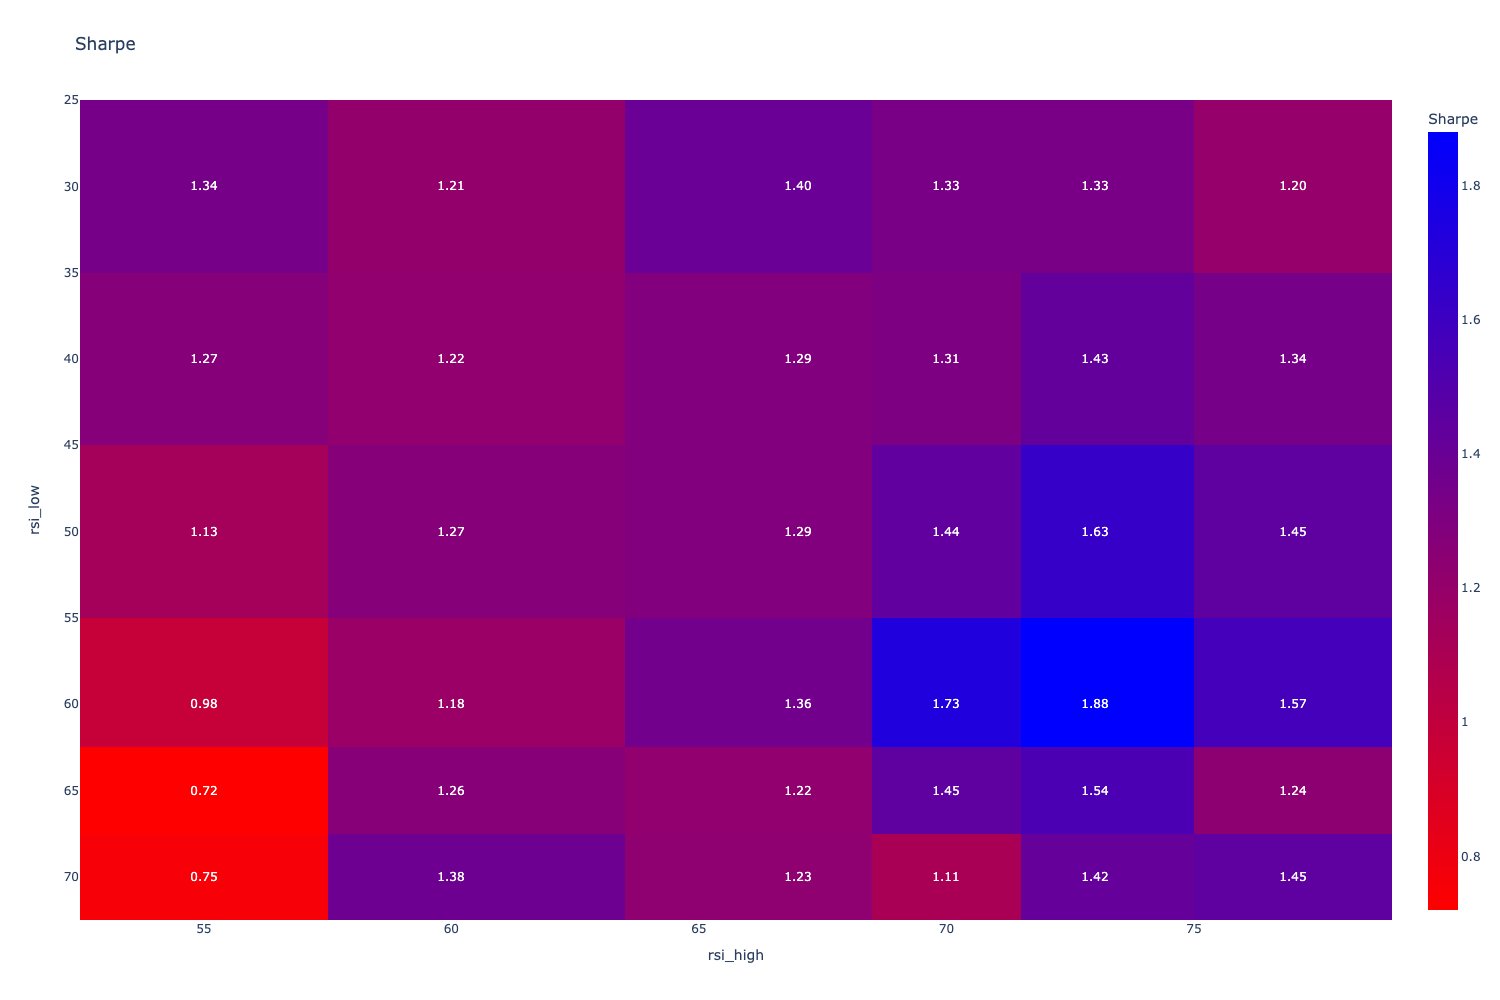

In [11]:
from tradeexecutor.analysis.grid_search import visualise_heatmap_2d


# RSI length = 8
heatmap_data = table.xs((8, pd.NA), level=("rsi_bars", "trailing_stop_loss"))

fig = visualise_heatmap_2d(heatmap_data, "rsi_low", "rsi_high", "Sharpe")
display(fig)


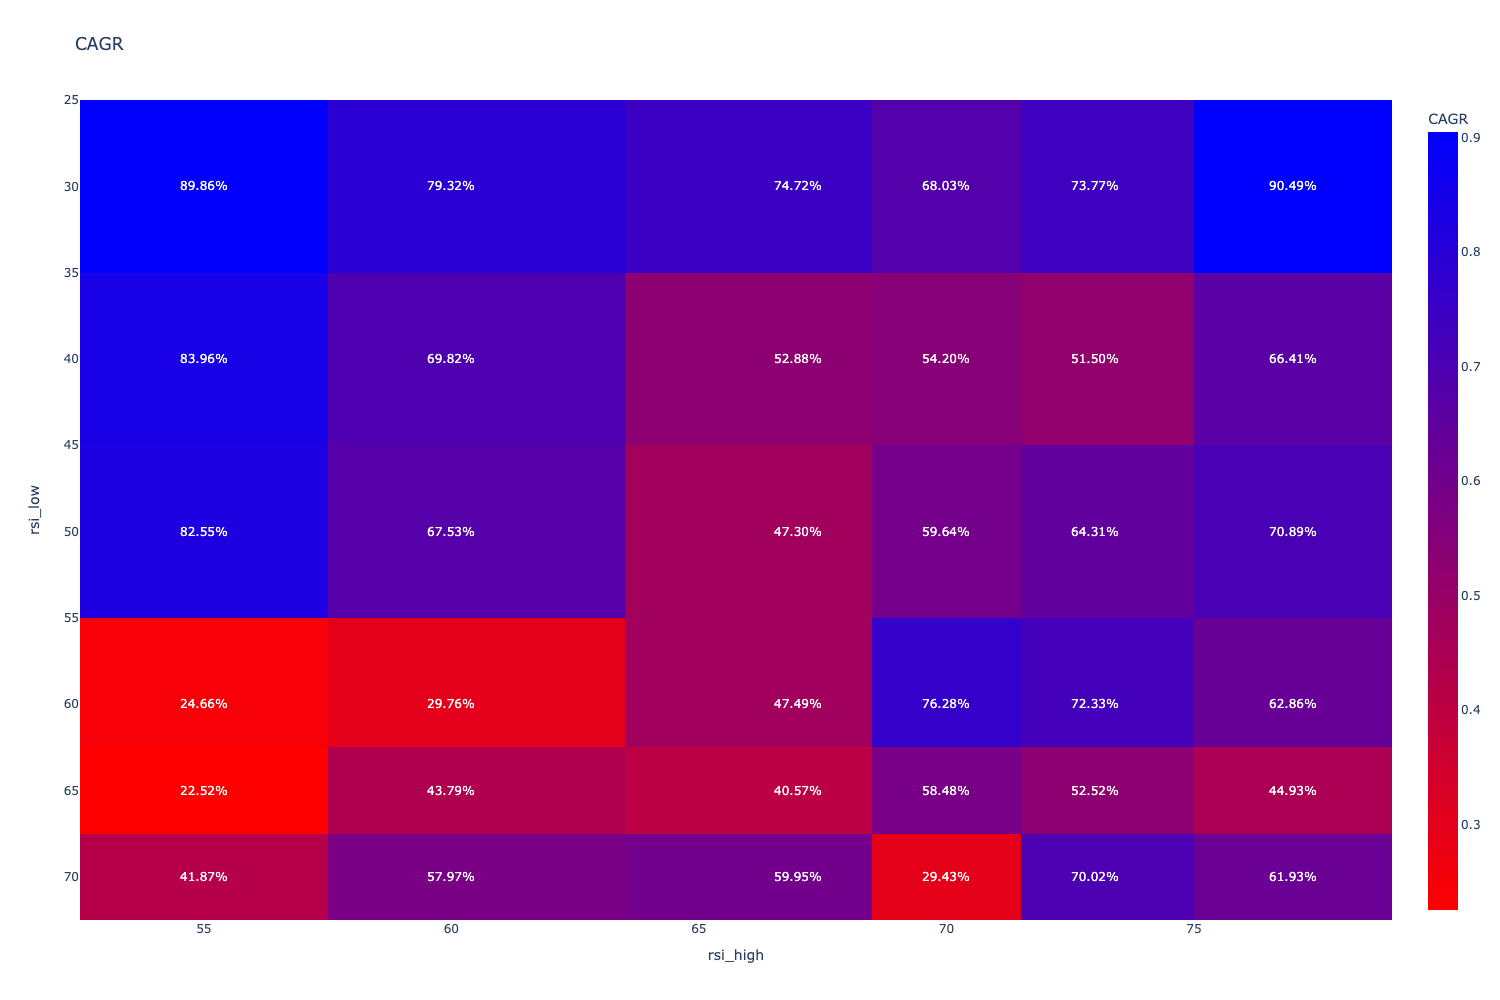

In [9]:
from tradeexecutor.analysis.grid_search import visualise_heatmap_2d


# RSI length = 9
heatmap_data = table.xs((9, pd.NA), level=("rsi_bars", "trailing_stop_loss"))

fig = visualise_heatmap_2d(heatmap_data, "rsi_low", "rsi_high", "CAGR")
display(fig)


# Equity curve comparison

- Compare the equity curves of all grid search results
- Show the grid search parameters as the tool tip
- Add buy and hold benchmarks on the plot

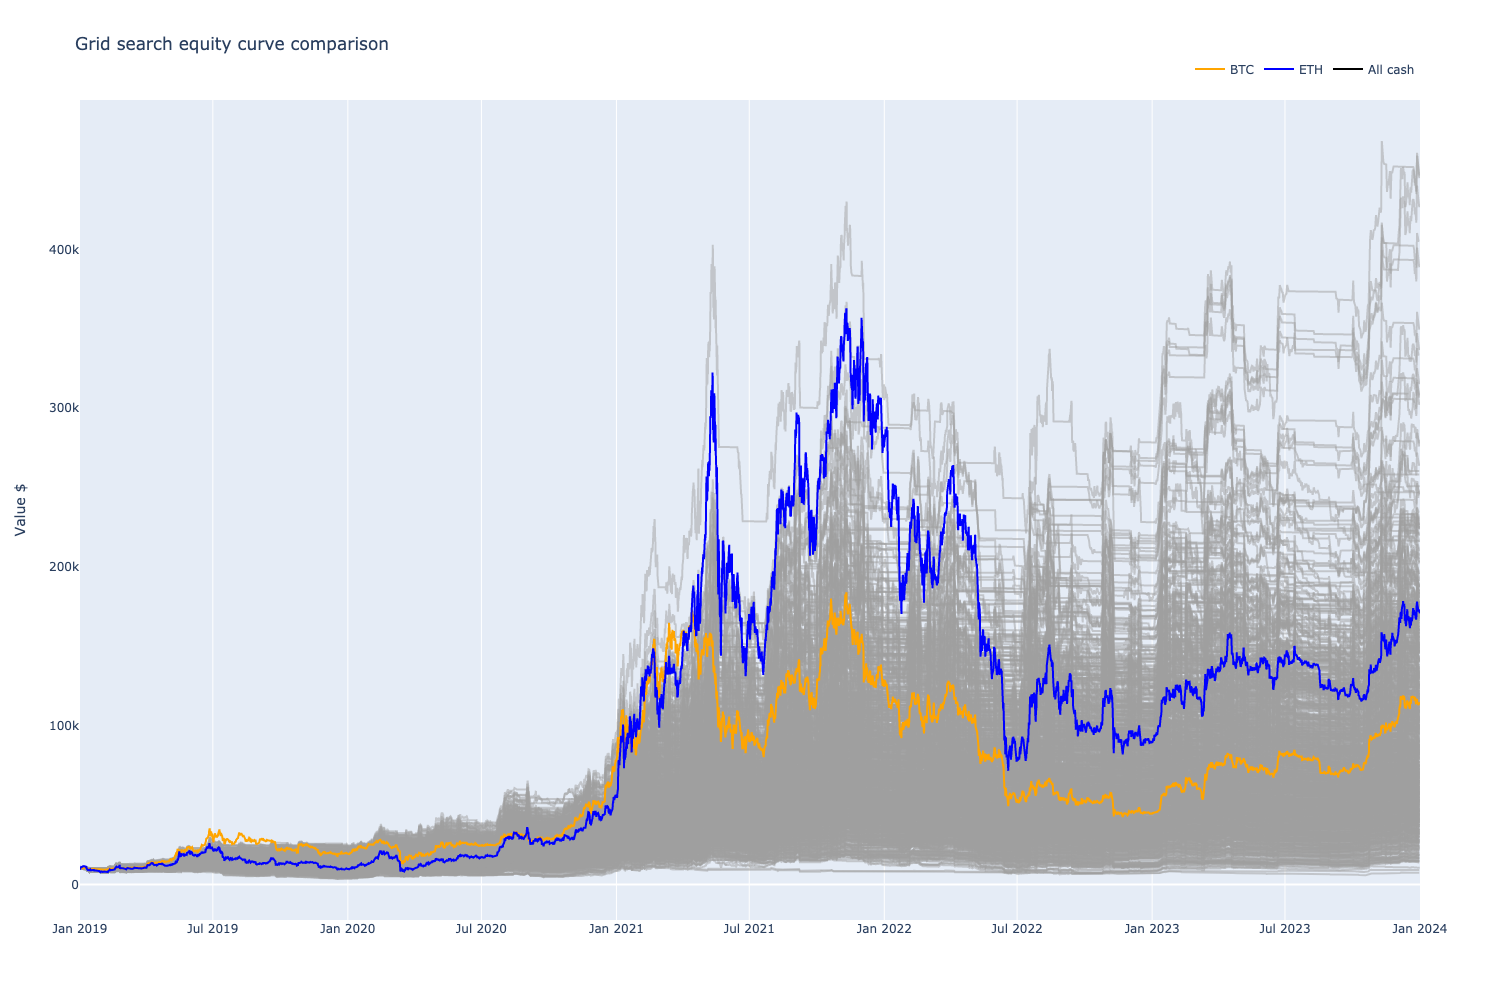

In [10]:
from tradeexecutor.analysis.grid_search import visualise_grid_search_equity_curves
from tradeexecutor.visual.benchmark import create_benchmark_equity_curves

benchmark_indexes = create_benchmark_equity_curves(
    strategy_universe,
    {"BTC": our_pairs[0], "ETH": our_pairs[1]},
    initial_cash=StrategyParameters.initial_cash,
)

fig = visualise_grid_search_equity_curves(
    grid_search_results,
    benchmark_indexes=benchmark_indexes,
    log_y=True,
)
fig.show()